### Equipment Fail Prediction

This notebook purpose is to analyse data collected from sensors on a equipment and ultimately develop a model to predict fails.

It's easy to imagine why such models are important for any industry. A fail in production could cost a lot of money to say the least. Running equipment until it fails should be the most costly option. Making too many preventive maintenance is also far from optimum and could also imply in money waste. This means that maintaining a machine when it really needs is the best option. The prediction model should meet this need as much as possible.

To approach this task, first an Exploratory Data Analysis is carried out. Then some transformations are done the get data ready for the prediction modelling. Finally, some comments end this document

# Set up

The assignment data was upload to a Google Drive folder so it could be easily accessed on a Google Colab Notebook.

In [ ]:
# dowloand and unzip the data
!gdown --id 1mG1dwy8GaZIyHXp26JDwpHrsrSfnazfD
!unzip 'O&G Equipment Data.zip'

Downloading...
From: https://drive.google.com/uc?id=1mG1dwy8GaZIyHXp26JDwpHrsrSfnazfD
To: /content/O&G Equipment Data.zip
100% 22.8k/22.8k [00:00<00:00, 21.5MB/s]
Archive:  O&G Equipment Data.zip
  inflating: O&G Equipment Data.csv  


In [ ]:
# common libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

In [ ]:
# import data from csv file into Pandas dataframe
df_orig = pd.read_csv('/content/O&G Equipment Data.csv', delimiter=';')
print(df_orig.shape)
df_orig.head(2)

(800, 10)


,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,"44,2352","47,6573","46,4418","64,8203","66,4545","44,4832",FALSO
1,2,2,4,"60,8072","63,1721","62,0060","80,7144","81,2464","60,2287",FALSO


In [ ]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Cycle        800 non-null    int64 
 1   Preset_1     800 non-null    int64 
 2   Preset_2     800 non-null    int64 
 3   Temperature  800 non-null    object
 4   Pressure     800 non-null    object
 5   VibrationX   800 non-null    object
 6   VibrationY   800 non-null    object
 7   VibrationZ   800 non-null    object
 8   Frequency    800 non-null    object
 9   Fail         800 non-null    object
dtypes: int64(3), object(7)
memory usage: 62.6+ KB


From the output above, we can see there are no missing values in the dataset, but import results presented  some problems: variables from 'Temperature' to 'Frequency' were expected to be of 'float' type, instead their types are 'object'. Also, they came with brazilian format for separating decimals (a comma istead of a period). The target variable ('Fail') was imported with an 'object' type, when a 'boolean' was expected. Let's fix these issues while we re-import the data.

In [ ]:
# checks 'Fail' possible values
df_orig['Fail'].unique()

array(['FALSO', 'VERDADEIRO'], dtype=object)

In [ ]:
# function to replace commas with periods and transform string to float
def string2float(x):
  return float(x.replace(',','.'))

In [ ]:
# import csv file applying corrections
df_orig = pd.read_csv('/content/O&G Equipment Data.csv', delimiter=';', true_values=['VERDADEIRO'], false_values=['FALSO'],
                   converters = {'Temperature': string2float,
                                 'Pressure': string2float,
                                 'VibrationX': string2float,
                                 'VibrationY': string2float,
                                 'VibrationZ': string2float,
                                 'Frequency': string2float
                                 }           
                   )
print(df_orig.shape)
df_orig.head(2)

(800, 10)


,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.2352,47.6573,46.4418,64.8203,66.4545,44.4832,False
1,2,2,4,60.8072,63.1721,62.0060,80.7144,81.2464,60.2287,False


In [ ]:
# Security copy
df = df_orig.copy(deep=True)

In [ ]:
# checks if dtypes are correct
df.dtypes

Cycle            int64
Preset_1         int64
Preset_2         int64
Temperature    float64
Pressure       float64
VibrationX     float64
VibrationY     float64
VibrationZ     float64
Frequency      float64
Fail              bool
dtype: object

Now that the data looks fine, let's explore it.

# Exploratoty Data Analysis

In [ ]:
# summary statistics for numerical (int and flooat) data
df.describe()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,1.988750,4.551250,69.263493,78.997944,73.860273,72.786877,71.866212,68.223448
std,231.0844,0.805875,2.293239,25.536251,32.501834,31.229629,32.739745,27.844618,29.138704
min,1.0000,1.000000,1.000000,2.089400,3.480300,3.846300,10.057700,18.784200,4.380100
25%,200.7500,1.000000,3.000000,51.040125,55.508550,50.752450,48.524000,50.787625,45.861725
50%,400.5000,2.000000,5.000000,65.906700,75.014850,69.394950,65.504750,69.319250,65.664300
75%,600.2500,3.000000,7.000000,80.527225,99.302500,90.195050,94.075600,88.891225,90.097425
max,800.0000,3.000000,8.000000,255.607800,189.995700,230.861100,193.569900,230.951100,178.090300


False    0.9175
True     0.0825
Name: Fail, dtype: float64


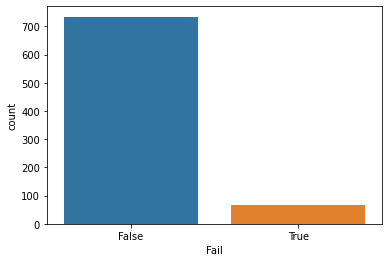

In [ ]:
# target distribution
print(df['Fail'].value_counts(normalize=True))
# plot
sns.countplot(x='Fail', data=df)
plt.show()

As expected for a equipament fail context, data is unbalanced: there are only 8.25% of fails in the dataset. This can be problematic for predict modeling purposes and will be dealt with later with a synthetic oversampling technique (SMOTE).

In [ ]:
# makes a list of variables for further analysis
feat = list(df.columns)
feat.remove('Cycle')
print(feat)

['Preset_1', 'Preset_2', 'Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency', 'Fail']


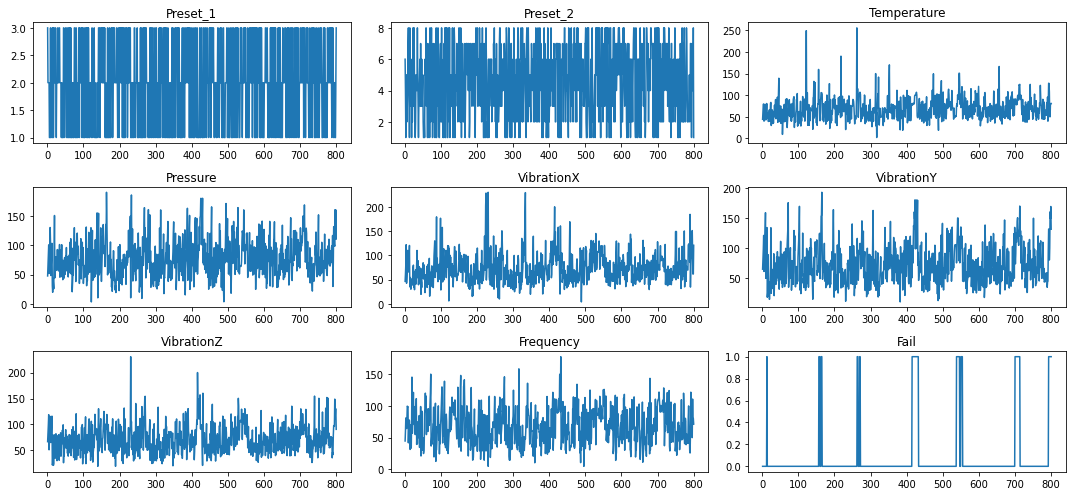

In [ ]:
# linear plots of each variable by cycle
fig, axs = plt.subplots(3, 3, figsize=(15,7))
for f in range(3):
  axs[0, f].plot(df['Cycle'], df[feat[f]])
  axs[0, f].set_title(feat[f])
  axs[1, f].plot(df['Cycle'], df[feat[f+3]])
  axs[1, f].set_title(feat[f+3])
  axs[2, f].plot(df['Cycle'], df[feat[f+6]])
  axs[2, f].set_title(feat[f+6])
fig.tight_layout()
plt.show()

Some interesting patterns can be viewed from the plots above. It seems that fails tend to occur when there are peaks in the values of the other variables.

In [ ]:
# checks cardinality for 'Preset_1' and 'Preset_2'
print('Preset_1 has {} unique values: {}'.format(df['Preset_1'].nunique(), df['Preset_1'].unique()))
print('Preset_2 has {} unique values: {}'.format(df['Preset_2'].nunique(), df['Preset_2'].unique()))

Preset_1 has 3 unique values: [3 2 1]
Preset_2 has 8 unique values: [6 4 1 3 5 2 7 8]


In [ ]:
# creates lists for 'int' and 'float' variables separately
# int
int_feat = [f for f in df.columns if df[f].dtype == 'int64']
int_feat.remove('Cycle')
print(int_feat)
# float
float_feat = [f for f in df.columns if df[f].dtype == 'float64']
print(float_feat)
target = ['Fail']

['Preset_1', 'Preset_2']
['Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']


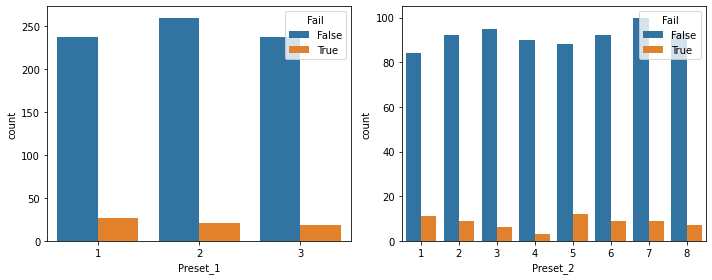

In [ ]:
# 'int' variables distribution
fig, axs = plt.subplots(1, 2, figsize=(10,4))
for i, f in enumerate(int_feat):
  sns.countplot(x=f, data=df, hue = 'Fail', ax=axs[i])
fig.tight_layout()
plt.show()

The graphics above show a slightly different fail ratio for 'Preset_1' values. These differences look more relevant in 'Preset_2'.

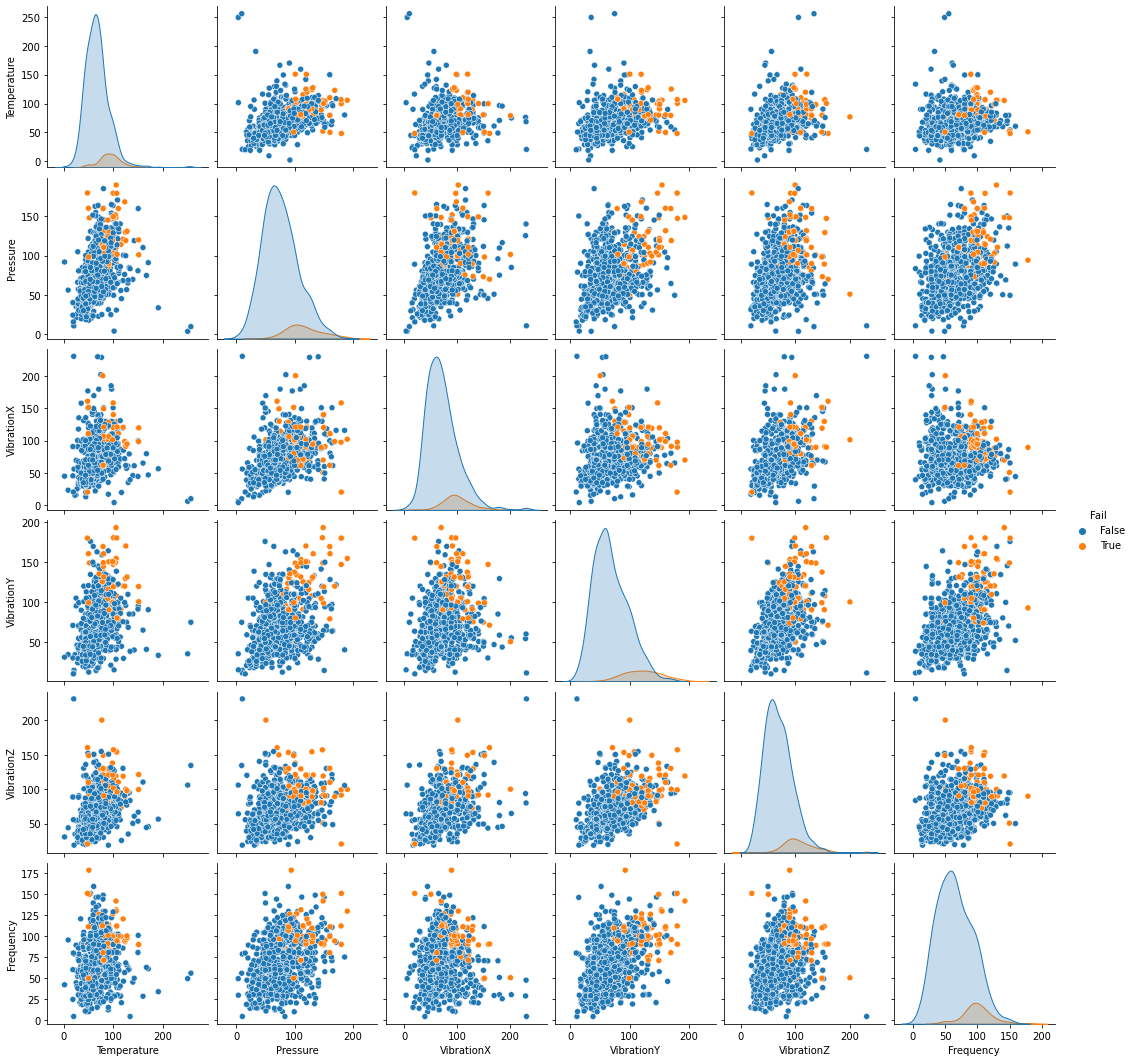

In [ ]:
# 'float' variables distribution and interaction
sns.pairplot(df, vars=float_feat, hue='Fail', kind='scatter', diag_kind='kde')

The scatter plots above confirm that fails tend to happen when variables reach higher values. Also, fail entries and non-fail entries seem to have different distributions.

Note that all 'float' variables seem to be in a similar scale. So scaling the variables won't be necessary if the model performs well. Keeping in mind the model deployment, it is always good to minimize data processing steps.

In [ ]:
# correlation heatmap function
def corr_heatmap(df, method):
  df_corr = df.iloc[:,:].corr(method=method)
  mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
  fig, ax = plt.subplots(figsize = (5, 5))
  sns.heatmap(df_corr, annot=True, vmin=-1, vmax=1, linewidths=.5, cmap='viridis', mask=mask, ax=ax)
  plt.show()

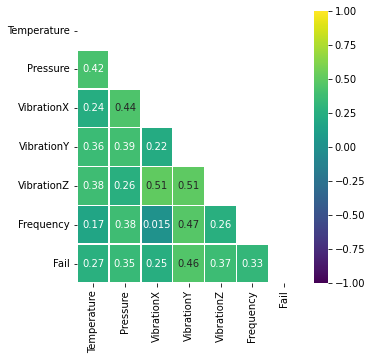

In [ ]:
# Pearson correlation heatmap 
corr_heatmap(df[float_feat + target], 'pearson')

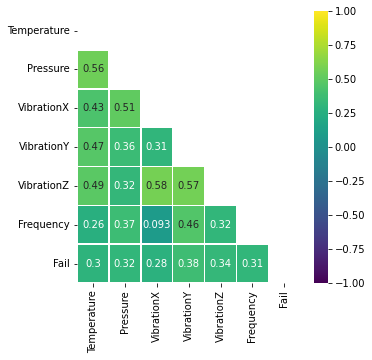

In [ ]:
# Spearman correlation heatmap 
corr_heatmap(df[float_feat + target], 'spearman')

Correlation heatmaps don't show any worrisome correlation between pairs of variables that could lead to multicollinearity

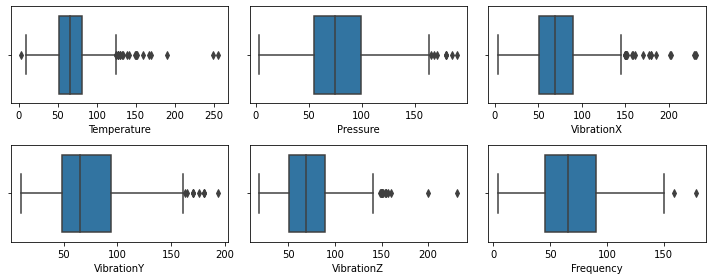

In [ ]:
# 'float' variables boxplots for outlier checking
fig, axs = plt.subplots(2, 3, figsize=(10,4))
for i in range(3):
  sns.boxplot(x=float_feat[i], data=df, hue = 'Fail', ax=axs[0, i])
  sns.boxplot(x=float_feat[i+3], data=df, hue = 'Fail', ax=axs[1, i])
fig.tight_layout()
plt.show()

Plots above show that there are indeed outliers for all 'float' variables. Let's quantify these outliers using the IQR method.

In [ ]:
# funciton to detect outliers based on IQR criteria
def outlier_detection(feature, df, low, up):
  q_low = df[feature].quantile(low)
  q_up = df[feature].quantile(up)
  iqr = q_up-q_low
  uf = q_up + 1.5*iqr
  lf = q_low - 1.5*iqr
  return(uf, lf)

In [ ]:
for f in float_feat:
  print('variable {}:'.format(f))
  uf, lf = outlier_detection(f, df, 0.25, 0.75)
  print('entries with value greater than {:.2f} (upper frontier): {} ({:.2f}%)'.format(
      uf, df.loc[df[f] > uf, :].Cycle.count(), df.loc[df[f] > uf, :].Cycle.count()/df.shape[0]*100))
  print('entries with value greater than {:.2f} (lower frontier): {} ({:.2f}%)'.format(
      lf, df.loc[df[f] > uf, :].Cycle.count(), df.loc[df[f] > uf, :].Cycle.count()/df.shape[0]*100))
  print("")

variable Temperature:
entries with value greater than 124.76 (upper frontier): 21 (2.62%)
entries with value greater than 6.81 (lower frontier): 21 (2.62%)

variable Pressure:
entries with value greater than 164.99 (upper frontier): 8 (1.00%)
entries with value greater than -10.18 (lower frontier): 8 (1.00%)

variable VibrationX:
entries with value greater than 149.36 (upper frontier): 20 (2.50%)
entries with value greater than -8.41 (lower frontier): 20 (2.50%)

variable VibrationY:
entries with value greater than 162.40 (upper frontier): 10 (1.25%)
entries with value greater than -19.80 (lower frontier): 10 (1.25%)

variable VibrationZ:
entries with value greater than 146.05 (upper frontier): 14 (1.75%)
entries with value greater than -6.37 (lower frontier): 14 (1.75%)

variable Frequency:
entries with value greater than 156.45 (upper frontier): 2 (0.25%)
entries with value greater than -20.49 (lower frontier): 2 (0.25%)



There are a few outliers in all 'float' variables, but they don't represent a relevant portion of data. In this case they could be replaced by each variables upper and lower variables according to IQR criteria. BUT, that must only be done after splitting data into train and validation subsets, to avoid leakage.

Let's further analyse the behaviour or the target variable and categorize equipment failures by setups configurations (preset 1 and preset 2)

In [ ]:
# safety copy
X = df.copy(deep=True)

In [ ]:
# creates a 'int' version of the target variable 
X['Fail_int'] = X['Fail'].map({False: 0, True: 1})
X['Fail_int'].value_counts()

0    734
1     66
Name: Fail_int, dtype: int64

In [ ]:
# entries count by preset combination
pd.pivot_table(df, values='Fail', index='Preset_1', columns='Preset_2', aggfunc='count')

Preset_2,1,2,3,4,5,6,7,8
Preset_1,,,,,,,,
1,34,38,43,22,31,34,38,24
2,30,34,26,40,40,37,37,37
3,31,29,32,31,29,30,34,39


In [ ]:
# Pivot table to check interaction among 'Preset 1', 'Preset _2' and 'Fail'
pd.pivot_table(df, values='Fail', index='Preset_1', columns='Preset_2', aggfunc='sum')

Preset_2,1,2,3,4,5,6,7,8
Preset_1,,,,,,,,
1,4,5,2,2,5,3,4,2
2,4,2,2,1,3,3,2,4
3,3,2,2,0,4,3,3,1


There are 24 possible combinations of 'Preset_1' and 'Preset_2'. The 1st pivot table above shows that entries are evenly distributed among preset combinations.

From the 2nd pivot table above one can note that there are combinations with less fails than others. One possible way to categorize fails is make groups with combinations of presets. Let's analyse how preset combinations behave on a ABC-like curve of cumulative fails.

In [ ]:
agg = X.groupby(['Preset_1', 'Preset_2'], as_index=False).Fail_int.sum()
agg = agg.sort_values(by='Fail_int', ascending=False)
agg['Fail_sum'] = agg[['Fail_int']].cumsum()
total = agg['Fail_int'].sum()
agg['Fail_perc'] = agg.apply(lambda x: x['Fail_sum']/total, axis=1)
agg.reset_index(drop=True, inplace=True)
agg

,Preset_1,Preset_2,Fail_int,Fail_sum,Fail_perc
0,1,2,5,5,0.075758
1,1,5,5,10,0.151515
2,1,1,4,14,0.212121
3,3,5,4,18,0.272727
4,1,7,4,22,0.333333
5,2,1,4,26,0.393939
6,2,8,4,30,0.454545
7,3,7,3,33,0.500000
8,3,6,3,36,0.545455
9,3,1,3,39,0.590909


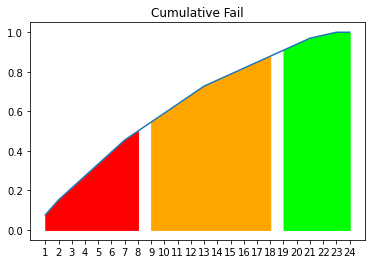

In [ ]:
# plots cumulative fail curve by preset combination
plt.plot(range(1, agg.shape[0]+1), agg['Fail_perc'])
plt.xticks(range(1, agg.shape[0]+1))
plt.fill_between(range(1, 9), agg.iloc[:8,-2], color='red')
plt.fill_between(range(9, 19), agg.iloc[8:18,-2], color='orange')
plt.fill_between(range(19, 25), agg.iloc[18:,-2], color='lime')
plt.title('Cumulative Fail')
plt.show()

Note that cumulative sum of fails raise faster in the begining of the curve and slows down in the end, showing that there are indeed groups of preset combinatios that cause more fails and others with less fails.

Colors in the plot above represent possible groups for preset combinations based on fail occurances. Red is the group of preset combinations that represents 50% of all fails. Likewise, Orange represents another 35% of fails. Green has only 15% of fails.

Thus, let's create preset categories based on these cuts.

In [ ]:
agg['preset_cat'] = agg['Fail_perc'].apply(lambda x: 'high fail' if x<=0.5 else ('medium fail' if x<=0.85 else 'low fail'))
agg.groupby('preset_cat', as_index=False).agg({'Fail_int': ['sum','count']})

preset_cat Fail_int      
                    sum count
0    high fail       33     8
1     low fail       10     7
2  medium fail       23     9

In [ ]:
def map_preset_cat(preset_1, preset_2):
  if preset_1 == 1:
    if preset_2 in [1, 2, 5, 7]:
      preset_cat = 'high fail'
    elif preset_2 in [2, 8]:
      preset_cat = 'medium fail'
    else:
      preset_cat = 'low fail'
  elif preset_1 == 2:
    if preset_2 in [1, 8]:
      preset_cat = 'high fail'
    elif preset_2 in [2, 3, 5, 6, 7]:
      preset_cat = 'medium fail'
    else:
      preset_cat = 'low fail'
  else:
    if preset_2 in [5, 7]:
      preset_cat = 'high fail'
    elif preset_2 in [1, 6]:
      preset_cat = 'medium fail'
    else:
      preset_cat = 'low fail'
  return preset_cat

In [ ]:
X['preset_cat'] = np.vectorize(map_preset_cat)(X['Preset_1'], X['Preset_2'])

In [ ]:
X.groupby('preset_cat', as_index=False).agg({'Fail_int': ['count', 'sum']})

preset_cat Fail_int    
                  count sum
0    high fail      271  33
1     low fail      270  13
2  medium fail      259  20

3 categories were created based on preset combinations according to fails concentration:


1.   high fail: concentrates 50% of fails and 34% of entries in the dataset
2.   medium fail: concentrates 30% of fails and 32% of entries in the dataset
3.   low fail: concentrates 20% of fails and 33% of entries in the dataset



Now let's see how the target variable behaves considering continuous variables and categorize equipment failures by their nature/root cause according to parameter readings (temperature, pressure, and others)

Stratification usually is a good method to identify root causes of problems. On the other hand, it can be impractical when there are too many variables to explore. An alternative is to use a Factor Analysis method to reduce the dimensionality of the problem to the main factors that represent the data, such as Principal Component Analysis (PCA) or t-Distributed Stochastic Neighbor Embedding (t-DSNE). Depending on the results all variables can be reduced to two main factors. That certainly simplies analysis, but factors are linear combinations of the original variables and interpretation of results can become difficult.

In this problem there are 6 variables to explore. For simplicity reasons, we'll follow the stratification approach, to keep interpretability of the categories created.

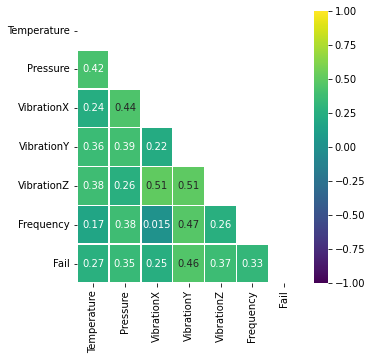

In [ ]:
# Pearson correlation heatmap 
corr_heatmap(X[float_feat + target], 'pearson')

Given the Pearson correlation heatmap above, a stratification analysis will be carried out from the variable with the highest correlation to the ones with the lowest correlation to the target (fails). This means the following order: 'VibrationY', 'VibrationZ', 'Pressure', 'Frequency', 'Temperature' and 'VibrationX'.

Also, in order to allow categorization with continuous features, the variables will be binned into quantiles.

In [ ]:
# creates new variables labeling the quantiles
for f in float_feat:
  X['{}_bin'.format(f)] = pd.qcut(X[f], q=4, labels=False)

In [ ]:
# function to generate report with fail details for a specific variable
def agg_bins(df, var):
  agg = df.groupby('{}_bin'.format(var), as_index=False).agg({'Fail': 'count', var: 'min', 'Fail_int': 'sum'})
  agg.rename(columns={'Fail': 'count', var: '{}_min'.format(var)}, inplace=True)
  agg = agg.sort_values(by='Fail_int', ascending=False)
  total = agg.Fail_int.sum()
  agg['Fail_perc'] = agg.apply(lambda x: x['Fail_int']/total, axis=1)
  agg['Fail_perc_cum'] = agg[['Fail_perc']].cumsum()
  agg['Fail_ratio'] = agg.apply(lambda x: x['Fail_int']/x['count'], axis=1)
  return(agg)

## VibrationY analysis

In [ ]:
agg_bins(X, 'VibrationY')

,VibrationY_bin,count,VibrationY_min,Fail_int,Fail_perc,Fail_perc_cum,Fail_ratio
3,3,200,94.0954,53,0.803030,0.803030,0.265
2,2,200,65.6029,12,0.181818,0.984848,0.060
1,1,200,48.5498,1,0.015152,1.000000,0.005
0,0,200,10.0577,0,0.000000,1.000000,0.000


80% of fails happen when VibrationY >= 94.0954 and another 18% when 48.5498 < VibrationY <= 65.6029. Together, these two groups concetrate 98% of fails.

VibrationY readings bellow ~79.24 (bins 0 and 1) present only 1 fail. All these entries will be put into a 'low fail' category.

VibrationY bins 2 and 3 have distinct fail ratios (=fail_int/count), 6% and 27% respectively. So they shall remain separete for further analysis.

In [ ]:
# initializes the readings category
X['readings_cat'] = ''
# sets 'low fail' category for:
X.loc[X['VibrationY_bin'].isin([0, 1]), ['readings_cat']] = 'low fail'

In [ ]:
X['readings_cat'].value_counts()

low fail    400
            400
Name: readings_cat, dtype: int64

### Stratification 1: VibrationY bin 3

VibrationZ analysis

In [ ]:
X_vibY_3 = X[X['VibrationY_bin']==3]
print('dataset rows after stratification = ', X_vibY_3.shape[0])
agg_bins(X_vibY_3, 'VibrationZ')

dataset rows after stratification =  200


,VibrationZ_bin,count,VibrationZ_min,Fail_int,Fail_perc,Fail_perc_cum,Fail_ratio
3,3,107,88.9540,42,0.792453,0.792453,0.392523
2,2,53,69.9877,9,0.169811,0.962264,0.169811
0,0,9,20.5226,1,0.018868,0.981132,0.111111
1,1,31,50.7992,1,0.018868,1.000000,0.032258


Of the 53 fails on from VibrationY bin 3, 42 (79%) happen when VibrationZ >= 88.9540. Another 9 fails (17%) happen when 69.9877 <= VibrationZ < 88.9450.

9 fails are still relevant (almost 14% of all fails). Also, fail ratio is very different between these two groups: Vibration_Z bin 3 has a 39% fail ration, while Vibration_Z bin 2 has 17%.

So another split in data will take place here for VibrationZ bins 2 and 3. Meanwhile, VibrationZ bins 0 and 1 only hold 2 fails, so they will also be set as 'low fail' category.

In [ ]:
# sets 'low fail' category for:
X.loc[(X['VibrationY_bin'] == 3) & (X['VibrationZ_bin'].isin([0, 1])), ['readings_cat']] = 'low fail'

In [ ]:
X['readings_cat'].value_counts()

low fail    440
            360
Name: readings_cat, dtype: int64

#### Stratification 1.1: VibrationY bin 3 and VibrationZ bin 3

Pressure analysis

In [ ]:
X_vibZ_3 = X_vibY_3[X_vibY_3['VibrationZ_bin']==3]
print('dataset rows after stratification = ', X_vibZ_3.shape[0])
agg_bins(X_vibZ_3, 'Pressure')

dataset rows after stratification =  107


,Pressure_bin,count,Pressure_min,Fail_int,Fail_perc,Fail_perc_cum,Fail_ratio
3,3,50,99.5124,33,0.785714,0.785714,0.660000
2,2,23,75.3689,8,0.190476,0.976190,0.347826
0,0,10,30.5316,1,0.023810,1.000000,0.100000
1,1,24,55.5378,0,0.000000,1.000000,0.000000


Pressure bin 3 has 66% of fails from the data cut above. The 8 fails presented on Pressure bin 2 are still worth investigation. The rest is not relevant regarding fail mapping

In [ ]:
# sets 'low fail' category for the combination of VibrationY bin 3, VibrationZ bin 3 and Pressure bins 0 and 1
X.loc[(X['VibrationY_bin'] == 3) & (X['VibrationZ_bin'] == 3) & (X['Pressure_bin'].isin([0, 1])), ['readings_cat']] = 'low fail'

In [ ]:
X['readings_cat'].value_counts()

low fail    474
            326
Name: readings_cat, dtype: int64

##### Stratification 1.1.1: VibrationY bin 3, VibrationZ bin 3 and Pressure Pressure bin 3

Frequency analysis

In [ ]:
X_press_3 = X_vibZ_3[X_vibZ_3['Pressure_bin']==3]
print('dataset rows after stratification = ', X_press_3.shape[0])
agg_bins(X_press_3, 'Frequency')

dataset rows after stratification =  50


,Frequency_bin,count,Frequency_min,Fail_int,Fail_perc,Fail_perc_cum,Fail_ratio
3,3,31,90.2143,22,0.666667,0.666667,0.709677
2,2,16,69.8039,11,0.333333,1.000000,0.687500
0,0,2,20.9000,0,0.000000,1.000000,0.000000
1,1,1,61.5139,0,0.000000,1.000000,0.000000


Similar to the previous steps, data with the highest concentration of fails will be stratified and the others classified as 'low fail'

In [ ]:
# sets 'low fail' category for the combination of bin 3 for VibrationY, VibrationZ, and Pressure and bins [0, 1] for Frequency 
X.loc[(X['VibrationY_bin'] == 3) & (X['VibrationZ_bin'] == 3) & (X['Pressure_bin'] == 3) & (X['Frequency_bin'].isin([0, 1]))
, ['readings_cat']] = 'low fail'

In [ ]:
X['readings_cat'].value_counts()

low fail    477
            323
Name: readings_cat, dtype: int64

###### Stratification 1.1.1.1: VibrationY bin 3, VibrationZ bin 3, Pressure bin 3 and Frequency bin 3.

Temperature analysis

In [ ]:
X_freq_3 = X_press_3[X_press_3['Frequency_bin']==3]
print('dataset rows after stratification = ', X_freq_3.shape[0])
agg_bins(X_freq_3, 'Temperature')

dataset rows after stratification =  31


,Temperature_bin,count,Temperature_min,Fail_int,Fail_perc,Fail_perc_cum,Fail_ratio
2,3,25,90.6625,19,0.863636,0.863636,0.76
1,2,5,70.2810,2,0.090909,0.954545,0.40
0,0,1,49.9853,1,0.045455,1.000000,1.00


Here Temperature bins 0 and 1 have only 3 fails combined. They will be set to 'low fail' and bin 3 will be further analysed.

In [ ]:
# sets 'low fail' category for the combination of bin 3 for VibrationY, VibrationZ, Pressure and Frequency and bins [0, 2] for Temperature 
X.loc[(X['VibrationY_bin'] == 3) & (X['VibrationZ_bin'] == 3) & (X['Pressure_bin'] == 3) & (X['Frequency_bin'] == 3) & (X['Temperature_bin'].isin([0, 2]))
, ['readings_cat']] = 'low fail'

In [ ]:
X['readings_cat'].value_counts()

low fail    483
            317
Name: readings_cat, dtype: int64

Stratification 1.1.1.1.1: VibrationY bin 3, VibrationZ bin 3, Pressure bin 3, Frequency bin 3 and Temperature bin 3

VibrationX analysis

In [ ]:
X_temp_3 = X_freq_3[X_freq_3['Temperature_bin']==3]
print('dataset rows after stratification = ', X_temp_3.shape[0])
agg_bins(X_temp_3, 'VibrationX')

dataset rows after stratification =  25


,VibrationX_bin,count,VibrationX_min,Fail_int,Fail_perc,Fail_perc_cum,Fail_ratio
1,3,21,90.7360,16,0.842105,0.842105,0.761905
0,2,4,69.8764,3,0.157895,1.000000,0.750000


After all these stratifications, there are only a few datapoints, but they represent the highest ratio fail in the dataset. Thus, they will both be set to 'high fail' category

In [ ]:
# sets 'high fail' category for:
X.loc[(X['VibrationY_bin'] == 3) & (X['VibrationZ_bin'] == 3) & (X['Pressure_bin'] == 3) & (X['Frequency_bin'] == 3) & (X['Temperature_bin'] == 3) & (X['VibrationX_bin'].isin([2, 3]))
, ['readings_cat']] = 'high fail'

In [ ]:
X['readings_cat'].value_counts()

low fail     483
             292
high fail     25
Name: readings_cat, dtype: int64

###### Stratification 1.1.1.2: VibrationY bin 3, VibrationZ bin 3, Pressure bin 3 and Frequency bin 2.

Temperature analysis

In [ ]:
X_freq_2 = X_press_3[X_press_3['Frequency_bin']==2]
print('dataset rows after stratification = ', X_freq_2.shape[0])
agg_bins(X_freq_2, 'Temperature')

dataset rows after stratification =  16


,Temperature_bin,count,Temperature_min,Fail_int,Fail_perc,Fail_perc_cum,Fail_ratio
1,3,10,80.8540,7,0.636364,0.636364,0.700000
0,2,6,75.8782,4,0.363636,1.000000,0.666667


High fail ratios. Keep digging.

Stratification 1.1.1.2.1: VibrationY bin 3, VibrationZ bin 3, Pressure bin 3, Frequency bin 2 and Temperature bin 3

VibrationX analysis

In [ ]:
X_temp_3 = X_freq_2[X_freq_2['Temperature_bin']==3]
print('dataset rows after stratification = ', X_temp_3.shape[0])
agg_bins(X_temp_3, 'VibrationX')

dataset rows after stratification =  10


,VibrationX_bin,count,VibrationX_min,Fail_int,Fail_perc,Fail_perc_cum,Fail_ratio
1,3,9,93.3759,6,0.857143,0.857143,0.666667
0,2,1,89.6920,1,0.142857,1.000000,1.000000


High fail ratio is set to 'high fail' category

In [ ]:
# sets 'high fail' category for:
X.loc[(X['VibrationY_bin'] == 3) & (X['VibrationZ_bin'] == 3) & (X['Pressure_bin'] == 3) & (X['Frequency_bin'] == 2) & (X['Temperature_bin'] == 3) & (X['VibrationX_bin'].isin([2, 3]))
, ['readings_cat']] = 'high fail'

In [ ]:
X['readings_cat'].value_counts()

low fail     483
             282
high fail     35
Name: readings_cat, dtype: int64

Stratification 1.1.1.2.2: VibrationY bin 3, VibrationZ bin 3, Pressure bin 3, Frequency bin 2 and Temperature bin 2

VibrationX analysis

In [ ]:
X_temp_2 = X_freq_2[X_freq_2['Temperature_bin']==2]
print('dataset rows after stratification = ', X_temp_2.shape[0])
agg_bins(X_temp_2, 'VibrationX')

dataset rows after stratification =  6


,VibrationX_bin,count,VibrationX_min,Fail_int,Fail_perc,Fail_perc_cum,Fail_ratio
0,1,2,61.3350,2,0.5,0.5,1.0
1,3,4,106.6685,2,0.5,1.0,0.5


High fail ratio is set to 'high fail' category

In [ ]:
# sets 'high fail' category for:
X.loc[(X['VibrationY_bin'] == 3) & (X['VibrationZ_bin'] == 3) & (X['Pressure_bin'] == 3) & (X['Frequency_bin'] == 2) & (X['Temperature_bin'] == 2) & (X['VibrationX_bin'].isin([1, 3]))
, ['readings_cat']] = 'high fail'

In [ ]:
X['readings_cat'].value_counts()

low fail     483
             276
high fail     41
Name: readings_cat, dtype: int64

##### Stratification 1.1.2: VibrationY bin 3, VibrationZ bin 3 and Pressure bin 2.

Frequency analysis

In [ ]:
X_press_2 = X_vibZ_3[X_vibZ_3['Pressure_bin']==2]
print('dataset rows after stratification = ', X_press_2.shape[0])
agg_bins(X_press_2, 'Frequency')

dataset rows after stratification =  23


,Frequency_bin,count,Frequency_min,Fail_int,Fail_perc,Fail_perc_cum,Fail_ratio
3,3,7,100.3499,5,0.625,0.625,0.714286
2,2,8,74.8806,2,0.250,0.875,0.250000
1,1,7,46.1136,1,0.125,1.000,0.142857
0,0,1,28.9601,0,0.000,1.000,0.000000


Frequency bins [0, 1, 2] have too little fail ratios, so will be set for 'low fail'. Bin 3 will be explored

In [ ]:
# sets 'low fail' category for:
X.loc[(X['VibrationY_bin'] == 3) & (X['VibrationZ_bin'] == 3) & (X['Pressure_bin'] == 2) & (X['Frequency_bin'].isin([0, 1, 2]))
, ['readings_cat']] = 'low fail'

In [ ]:
X['readings_cat'].value_counts()

low fail     499
             260
high fail     41
Name: readings_cat, dtype: int64

###### Stratification 1.1.2.1: VibrationY bin 3, VibrationZ bin 3 and Pressure bin 2 and Frequency bin 3.

Temperature analysis

In [ ]:
X_freq_3 = X_press_2[X_press_2['Frequency_bin']==3]
print('dataset rows after stratification = ', X_freq_3.shape[0])
agg_bins(X_freq_3, 'Temperature')

dataset rows after stratification =  7


,Temperature_bin,count,Temperature_min,Fail_int,Fail_perc,Fail_perc_cum,Fail_ratio
0,2,5,67.2790,3,0.6,0.6,0.6
1,3,2,81.5463,2,0.4,1.0,1.0


High fail ratio is set to 'high fail' category

In [ ]:
# sets 'high fail' category for:
X.loc[(X['VibrationY_bin'] == 3) & (X['VibrationZ_bin'] == 3) & (X['Pressure_bin'] == 2) & (X['Frequency_bin'] == 3) & (X['Frequency_bin'].isin([2, 3]))
, ['readings_cat']] = 'high fail'

In [ ]:
X['readings_cat'].value_counts()

low fail     499
             253
high fail     48
Name: readings_cat, dtype: int64

#### Stratification 1.2: VibrationY bin 3 and VibrationZ bin 2.

Pressure analysis

In [ ]:
X_vibZ_2 = X_vibY_3[X_vibY_3['VibrationZ_bin']==2]
print('dataset rows after stratification = ', X_vibZ_2.shape[0])
agg_bins(X_vibZ_2, 'Pressure')

dataset rows after stratification =  53


,Pressure_bin,count,Pressure_min,Fail_int,Fail_perc,Fail_perc_cum,Fail_ratio
3,3,23,99.4641,7,0.777778,0.777778,0.304348
2,2,13,75.0690,2,0.222222,1.000000,0.153846
0,0,4,35.0665,0,0.000000,1.000000,0.000000
1,1,13,58.5220,0,0.000000,1.000000,0.000000


Pressure bins [0, 1, 2] have low fail ratio and will be set to 'low fail' category. As for bin 3, it will be stratified.

In [ ]:
# sets 'low fail' category for:
X.loc[(X['VibrationY_bin'] == 3) & (X['VibrationZ_bin'] == 2) & (X['Pressure_bin'].isin([0, 1, 2]))
, ['readings_cat']] = 'low fail'

In [ ]:
X['readings_cat'].value_counts()

low fail     529
             223
high fail     48
Name: readings_cat, dtype: int64

##### Stratification 1.2.1: VibrationY bin 3, VibrationZ bin 2 and Pressure bin 3

Frequency analysis

In [ ]:
X_pres_3 = X_vibZ_2[X_vibZ_2['Pressure_bin']==3]
print('dataset rows after stratification = ', X_pres_3.shape[0])
agg_bins(X_pres_3, 'Frequency')

dataset rows after stratification =  23


,Frequency_bin,count,Frequency_min,Fail_int,Fail_perc,Fail_perc_cum,Fail_ratio
3,3,15,90.6251,7,1.0,1.0,0.466667
0,0,2,40.1286,0,0.0,1.0,0.000000
1,1,2,50.6091,0,0.0,1.0,0.000000
2,2,4,68.0102,0,0.0,1.0,0.000000


Frequency bins [0, 1, 2] have low fail ratio and will be set to 'low fail' category. As for bin 3, it will be stratified.

In [ ]:
# sets 'low fail' category for:
X.loc[(X['VibrationY_bin'] == 3) & (X['VibrationZ_bin'] == 2) & (X['Pressure_bin'] == 3) & (X['Frequency_bin'].isin([0, 1, 2]))
, ['readings_cat']] = 'low fail'

In [ ]:
X['readings_cat'].value_counts()

low fail     537
             215
high fail     48
Name: readings_cat, dtype: int64

###### Stratification 1.2.1.1: VibrationY bin 3, VibrationZ bin 2, Pressure bin 3 and Frequency 3

Temperature Analysis

In [ ]:
X_freq_3 = X_pres_3[X_pres_3['Frequency_bin']==3]
print('dataset rows after stratification = ', X_freq_3.shape[0])
agg_bins(X_freq_3, 'Temperature')

dataset rows after stratification =  15


,Temperature_bin,count,Temperature_min,Fail_int,Fail_perc,Fail_perc_cum,Fail_ratio
0,2,9,69.972,4,0.571429,0.571429,0.444444
1,3,6,81.597,3,0.428571,1.000000,0.500000


High fail ratios for both bins

In [ ]:
# sets 'high fail' category for:
X.loc[(X['VibrationY_bin'] == 3) & (X['VibrationZ_bin'] == 2) & (X['Pressure_bin'] == 3) & (X['Frequency_bin'] == 3) & (X['Temperature_bin'].isin([2, 3]))
, ['readings_cat']] = 'high fail'

In [ ]:
X['readings_cat'].value_counts()

low fail     537
             200
high fail     63
Name: readings_cat, dtype: int64

### Stratification 2: VibrationY bin 2

VibrationZ analysis

In [ ]:
X_vibY_2 = X[X['VibrationY_bin']==2]
print('dataset rows after stratification = ', X_vibY_2.shape[0])
agg_bins(X_vibY_2, 'VibrationZ')

dataset rows after stratification =  200


,VibrationZ_bin,count,VibrationZ_min,Fail_int,Fail_perc,Fail_perc_cum,Fail_ratio
3,3,51,89.2787,10,0.833333,0.833333,0.196078
2,2,77,69.3413,2,0.166667,1.000000,0.025974
0,0,25,26.9242,0,0.000000,1.000000,0.000000
1,1,47,51.0880,0,0.000000,1.000000,0.000000


In [ ]:
# sets 'low fail' category for VibrationY bins 2 and VibrationZ bin [0, 1, 2]
X.loc[(X['VibrationY_bin']==2) & (X['VibrationZ_bin'].isin([0, 1, 2])), ['readings_cat']] = 'low fail'

In [ ]:
X['readings_cat'].value_counts()

low fail     686
high fail     63
              51
Name: readings_cat, dtype: int64

#### Stratification 2.1: VibrationY bin 2 and VibrationZ bin 3

Pressure analysis

In [ ]:
X_vibZ_3 = X_vibY_2[X_vibY_2['VibrationZ_bin']==3]
print('dataset rows after stratification = ', X_vibZ_3.shape[0])
agg_bins(X_vibZ_3, 'Pressure')

dataset rows after stratification =  51


,Pressure_bin,count,Pressure_min,Fail_int,Fail_perc,Fail_perc_cum,Fail_ratio
2,2,16,75.2176,4,0.4,0.4,0.250000
1,1,18,58.5624,3,0.3,0.7,0.166667
3,3,9,100.0892,3,0.3,1.0,0.333333
0,0,8,9.4553,0,0.0,1.0,0.000000


No longer relevant

In [ ]:
# sets 'low fail' category for VibrationY bin 2 and VibrationZ bin 3
X.loc[(X['VibrationY_bin']==2) & (X['VibrationZ_bin']==3)
, ['readings_cat']] = 'low fail'

In [ ]:
X['readings_cat'].value_counts()

low fail     737
high fail     63
Name: readings_cat, dtype: int64

In [ ]:
X.groupby('readings_cat', as_index=False)[float_feat].mean()

,readings_cat,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency
0,high fail,95.068814,123.068265,95.518273,127.080627,100.254049,99.479887
1,low fail,67.057611,75.230739,72.008911,68.145756,69.439572,65.551595


In [ ]:
X.groupby('readings_cat', as_index=False)[float_feat].min()

,readings_cat,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency
0,high fail,67.2790,80.4130,61.3350,94.1925,70.6778,69.8039
1,low fail,2.0894,3.4803,3.8463,10.0577,18.7842,4.3801


In [ ]:
X.groupby('readings_cat', as_index=False).agg({'Fail_int': ['count', 'sum']})

readings_cat Fail_int    
                  count sum
0    high fail       63  42
1     low fail      737  24

In the end only two categories were necessary to understand the root cause of fails and segregate data. This happend because fails tend to happen with high incidence when the values raise to peaks for all variables.

Stratification turned out to be extensive, but resulted in two very distinct categories, as shown by the average values and amount of fails and total entries in each group. Category 'high fail' is labeled when sensor readins show:

*   Temperature >= 67.2790
*   Pressure >= 80.4130
*   VibrationX >= 61.3350
*   VibrationY >= 94.1925
*   VibrationZ >= 70.6778
*   Frequency >= 69.8039

Otherwise, entries are labeled as 'low fail'.



## Data preprocessing for Fail Prediction

In equipament fail prediction problems it's often useful to use moving summaries of variables, like mean, median, min a max. Time lenght is relevant and must be consistent with the problem and the business reality. Here it will be set arbitrarily in 10 cycles for lack of domain knowledge.

In [ ]:
# define feature window
feature_window = 10

In [ ]:
# apply moving summaries to 'float' variables
for f in float_feat:
  df['{}_mean'.format(f)] = df[f].rolling(window=feature_window, min_periods=1).mean()
  df['{}_median'.format(f)] = df[f].rolling(window=feature_window, min_periods=1).median()
  df['{}_max'.format(f)] = df[f].rolling(window=feature_window, min_periods=1).max()
  df['{}_min'.format(f)] = df[f].rolling(window=feature_window, min_periods=1).min()

Another important definition is how much time before the event of failure the company needs to act with counter measures to avoid the fail. This decision should also be based on domain knowledge and the envolvement of domain experts is crucial to do it well. Here it will be arbitrarily set to 5 cycles.

This definition changes the target variable in a sense that what will be predict now is the probability of a fail event withn the target window length.

In [ ]:
target_window = 5

In [ ]:
# creates new target based on target window
for i in range(1,target_window):
  df['Fail_lead_{}'.format(i)] = df['Fail'].shift(-i)

df['Fail_window'] = df.apply(lambda x: True if (x['Fail']
                             or x['Fail_lead_1']==True
                             or x['Fail_lead_2']==True
                             or x['Fail_lead_3']==True
                             or x['Fail_lead_4']==True
                             ) else False, axis=1)

False    0.87
True     0.13
Name: Fail_window, dtype: float64


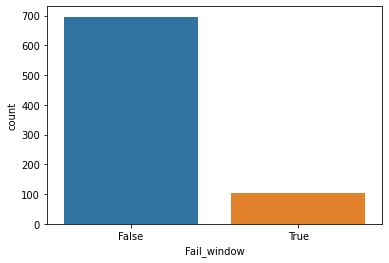

In [ ]:
print(df['Fail_window'].value_counts(normalize=True))
sns.countplot(x='Fail_window', data=df)

This change in the target variable raised fail ratio grom 8.25% to 13%, which is good for training the models.

In [ ]:
# list with independent variables
x = ['Preset_1','Preset_2','Temperature','Pressure','VibrationX','VibrationY','VibrationZ','Frequency','Temperature_mean','Temperature_median','Temperature_max',
     'Temperature_min','Pressure_mean','Pressure_median','Pressure_max','Pressure_min','VibrationX_mean','VibrationX_median','VibrationX_max','VibrationX_min',
     'VibrationY_mean','VibrationY_median','VibrationY_max','VibrationY_min','VibrationZ_mean','VibrationZ_median','VibrationZ_max','VibrationZ_min','Frequency_mean',
     'Frequency_median','Frequency_max','Frequency_min'
]

In [ ]:
# sets X for independent variables and y for the target
X = df[x + ['Fail_window']]
y = X.pop('Fail_window')

In [ ]:
# splits data into train and validation
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=16, stratify=y)
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(640, 32)
(160, 32)
(640,)
(160,)


In [ ]:
# import lib for SMOTE oversampling
from imblearn.over_sampling import SMOTE

In [ ]:
# applies SMOTE only in training data
oversample = SMOTE()
X_train_res, y_train_res = oversample.fit_resample(X_train, y_train)
# original data fail ratio
print('fail ratio before SMOTE:', np.sum(y_train)/len(y_train))
# fail ratio after smote
print('fail ratio after SMOTE:', np.sum(y_train_res)/len(y_train_res))

fail ratio before SMOTE: 0.1296875
fail ratio after SMOTE: 0.5


Notice that SMOTE oversampling lead to a balanced dataset.

In [ ]:
X_train_res.shape

(1114, 32)

## Modeling

In [ ]:
# functions to evaluate models regarding accuracy

from sklearn.model_selection import cross_val_score, StratifiedKFold

def get_mean_accuracy(model, X, y):
    #Implemente a função get_mean_accuracy aqui
    cv = StratifiedKFold(n_splits=10)
    score = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return score.mean()

def evaluate_models(models, X, y):
    #Implemente a função evaluate_models aqui
    for m in models:
        acc = get_mean_accuracy(models[m], X, y)
        print('Model {} accuracy: {}'.format(m, acc))

In [ ]:
# Check different models with deafult configs:
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {"logreg": LogisticRegression(),
          "SVM": SVC(),
          "MLP": MLPClassifier(),
          "DT": DecisionTreeClassifier(),
          "RF": RandomForestClassifier(),
          "XGB":XGBClassifier()
         }

In [ ]:
%%time
evaluate_models(models, X_train, y_train)

Model logreg accuracy: 0.8828125
Model SVM accuracy: 0.9234375
Model MLP accuracy: 0.8734375
Model DT accuracy: 0.9453125
Model RF accuracy: 0.965625
Model XGB accuracy: 0.9703125
CPU times: user 392 ms, sys: 64.8 ms, total: 457 ms
Wall time: 8.71 s


XGBoost Classifier got the best accuracy and will be the selected model through the rest of the analysis, for simplification purposes.

In [ ]:
# install package to optimize hyperparameters
!pip install scikit-optimize

     |████████████████████████████████| 100 kB 3.5 MB/s 


In [ ]:
from skopt import BayesSearchCV

In [ ]:
%%time
import warnings
warnings.filterwarnings('ignore')

opt = BayesSearchCV(
    XGBClassifier(),
    {
        'learning_rate': (1e-5, 1e-1, 'log-uniform'),
        'min_split_loss': [0.05, 0.1, 0.3, 0.5, 0.75, 1],
        'max_depth': (3, 15),
        'min_child_weight': (3, 7),
        'subsample': (1e-2, 0.9999, 'log-uniform'),
        'colsample_bytree': (1e-2, 0.9999, 'log-uniform'),
        'reg_lambda': (1e-2, 0.9999, 'log-uniform'),
        'reg_alpha': (1e-2, 0.9999, 'log-uniform'),
    },
    n_iter=32,
    cv=3,
    n_jobs=-1,
    scoring='accuracy'
)

opt.fit(X_train, y_train)

print("test score: %s" % opt.best_score_)
print("valid score: %s" % opt.score(X_valid, y_valid))
print("best params: %s" % str(opt.best_params_))

test score: 0.9609494976087052
valid score: 0.96875
best params: OrderedDict([('colsample_bytree', 0.9999), ('learning_rate', 0.1), ('max_depth', 3), ('min_child_weight', 3), ('min_split_loss', 0.05), ('reg_alpha', 0.04999358917496491), ('reg_lambda', 0.01), ('subsample', 0.9999)])
CPU times: user 54.6 s, sys: 22.9 s, total: 1min 17s
Wall time: 1min


### **The XGBoost model got an accuracy of 97% in the cross validation training and a 98% accuracy on validation dataset. This means that it is very accurate predicting when a fail will occur within the target windown.**

It's very important to evaluate other metrics in order to check model's performance. In equipament fail context the costs involved in maintance or repair of the equipament is of capital importance. It's likely better for the model to miss false positives (that would mean to make a preventive maintanance when a fail would not really occur) than miss false negative (the model don't sound the alarm for failure, but it occurs). Of course, it's ideal to minimize both.

              precision    recall  f1-score   support

       False       0.99      0.99      0.99       139
        True       0.91      0.95      0.93        21

    accuracy                           0.98       160
   macro avg       0.95      0.97      0.96       160
weighted avg       0.98      0.98      0.98       160



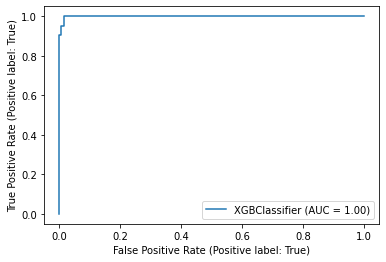

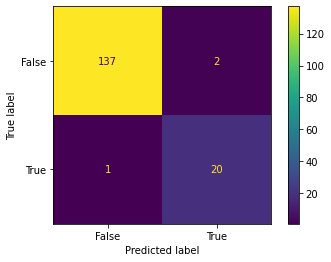

In [ ]:
# print classification report with precision, recall and f1-score metrics; confusion matrix and AUC ROC Curve
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve

y_pred = opt.best_estimator_.predict(X_valid)

print(classification_report(y_valid, y_pred))

plot_roc_curve(opt.best_estimator_, X_valid, y_valid)

plot_confusion_matrix(opt.best_estimator_, X_valid, y_valid)

plt.show()

The model performs very well on all metrics. Results are also satisfatory looking at the confusion matrix: the model only got 2 false positives (1.25%) and 1 false negative (0.63%). Note that all the performance evaluation was done on the validation set, which contains data never seen by the model during training.

## Analyze variable importance

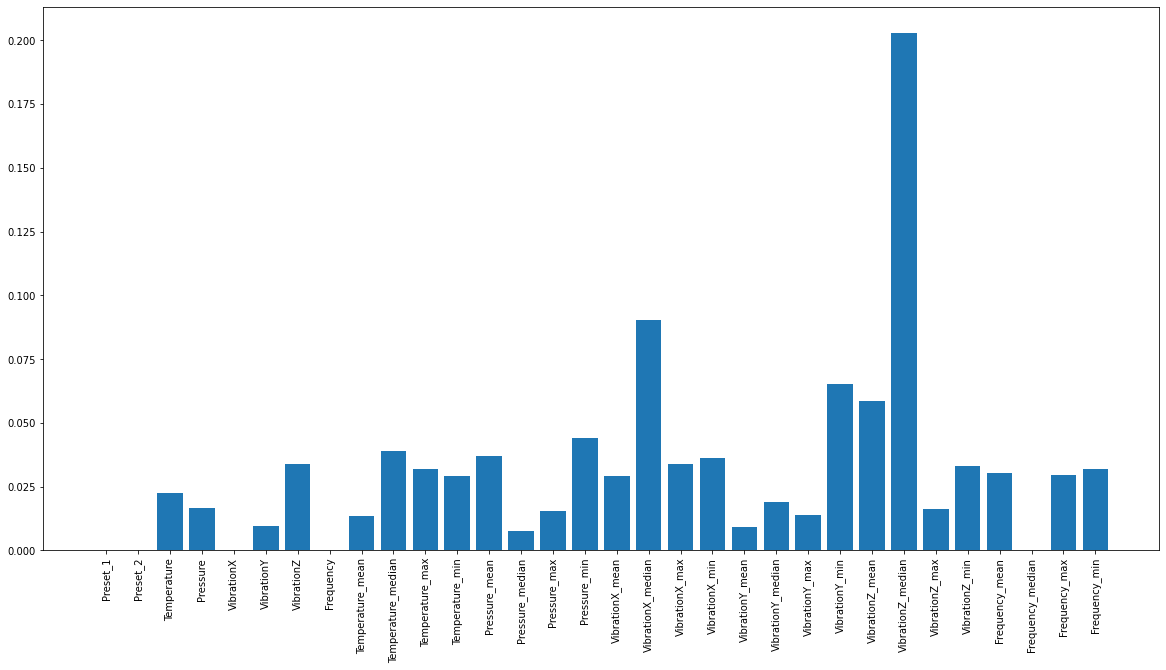

In [ ]:
# plot feature importance
importance = opt.best_estimator_.feature_importances_
plt.figure(figsize=(20,10))
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(range(len(importance)), X.columns, rotation=90)
plt.show()

The barplot above shows feature importance for every variable used in the model.

Highlights:

The most important variable is, by far, the moving median value of 5 cycles for VibrationZ. Then there's the moving median value of 5 cycles for VibrationX, followed by the moving minimum value of 5 cycles for VibrationY and the moving average value of 5 cycles for VibrationZ.

# Final considerations

In this notebook several techniques were applied to adjust, explore, transform and get insights from data in order to address the questions from the hard skill test. Presented results were at satisfactory, specially the fail prediction model elaborated. If these results could be replicated to real business data this model would create amazing value to the company and other stakeholders.
